<a href="https://colab.research.google.com/github/cottonbhimireddy1/Chips-category-analysis/blob/main/trail_vs_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
# Load dataset
data = pd.read_csv("/content/QVI_data.csv")

print("Shape:", data.shape)
print("\nColumns:", list(data.columns))

# Preview
display(data.head(5))

# Quick check for key columns
required_cols = ["STORE_NBR", "DATE", "TOT_SALES", "LYLTY_CARD_NBR", "TXN_ID"]
missing = [c for c in required_cols if c not in data.columns]
print("\nMissing required columns:", missing if missing else "None ✅")

# Data types
print("\nDtypes:")
print(data[ [c for c in required_cols if c in data.columns] ].dtypes)


Shape: (264834, 12)

Columns: ['LYLTY_CARD_NBR', 'DATE', 'STORE_NBR', 'TXN_ID', 'PROD_NBR', 'PROD_NAME', 'PROD_QTY', 'TOT_SALES', 'PACK_SIZE', 'BRAND', 'LIFESTAGE', 'PREMIUM_CUSTOMER']


,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream



Missing required columns: None ✅

Dtypes:
STORE_NBR           int64
DATE               object
TOT_SALES         float64
LYLTY_CARD_NBR      int64
TXN_ID              int64
dtype: object


In [ ]:
# FORCE convert DATE column to datetime (robust fix)
data["DATE"] = pd.to_datetime(data["DATE"], errors="coerce")

# Verify conversion
print(data["DATE"].dtype)
print("Null dates after conversion:", data["DATE"].isna().sum())

# Create year-month column
data["YEAR_MONTH"] = data["DATE"].dt.to_period("M").astype(str)

# Monthly metrics per store
monthly_store = (
    data
    .groupby(["STORE_NBR", "YEAR_MONTH"])
    .agg(
        total_sales=("TOT_SALES", "sum"),
        customers=("LYLTY_CARD_NBR", "nunique"),
        transactions=("TXN_ID", "nunique")
    )
    .reset_index()
)

# Avg transactions per customer
monthly_store["avg_txn_per_customer"] = (
    monthly_store["transactions"] / monthly_store["customers"]
)

display(monthly_store.head())


datetime64[ns]
Null dates after conversion: 0


,STORE_NBR,YEAR_MONTH,total_sales,customers,transactions,avg_txn_per_customer
0,1,2018-07,206.9,49,52,1.061224
1,1,2018-08,176.1,42,43,1.023810
2,1,2018-09,278.8,59,62,1.050847
3,1,2018-10,188.1,44,45,1.022727
4,1,2018-11,192.6,46,47,1.021739


In [ ]:
# ---- DEFINE PRE-TRIAL AND TRIAL PERIODS (MONTHLY) ----

trial_start = "2018-02"  # standard in Quantium task

monthly_store["PERIOD"] = np.where(
    monthly_store["YEAR_MONTH"] < trial_start,
    "PRE_TRIAL",
    "TRIAL"
)

print(monthly_store["PERIOD"].value_counts())
display(monthly_store.head())



PERIOD
TRIAL    3169
Name: count, dtype: int64


,STORE_NBR,YEAR_MONTH,total_sales,customers,transactions,avg_txn_per_customer,PERIOD
0,1,2018-07,206.9,49,52,1.061224,TRIAL
1,1,2018-08,176.1,42,43,1.023810,TRIAL
2,1,2018-09,278.8,59,62,1.050847,TRIAL
3,1,2018-10,188.1,44,45,1.022727,TRIAL
4,1,2018-11,192.6,46,47,1.021739,TRIAL


In [ ]:
# ---- DEFINE TRIAL STORES (FROM TASK BRIEF) ----

trial_stores = [77, 86, 88]

print("Trial stores:", trial_stores)


Trial stores: [77, 86, 88]


In [ ]:
import pandas as pd
import numpy as np

monthly_store["YEAR_MONTH_P"] = pd.PeriodIndex(monthly_store["YEAR_MONTH"], freq="M")

trial_start_p = pd.Period("2019-01", freq="M")

monthly_store["PERIOD"] = np.where(
    monthly_store["YEAR_MONTH_P"] < trial_start_p,
    "PRE_TRIAL",
    "TRIAL"
)

print(monthly_store["PERIOD"].value_counts())

for s in [77, 86, 88]:
    print("\nStore", s)
    print(monthly_store[monthly_store["STORE_NBR"]==s]["PERIOD"].value_counts())


PERIOD
PRE_TRIAL    1585
TRIAL        1584
Name: count, dtype: int64

Store 77
PERIOD
PRE_TRIAL    6
TRIAL        6
Name: count, dtype: int64

Store 86
PERIOD
PRE_TRIAL    6
TRIAL        6
Name: count, dtype: int64

Store 88
PERIOD
PRE_TRIAL    6
TRIAL        6
Name: count, dtype: int64


In [ ]:
def score_control_candidates(trial_store, metric, min_months=6):
    """
    Scores all potential control stores against a trial store using PRE_TRIAL data.
    Uses:
      - Pearson correlation (trend similarity)
      - Magnitude distance score (level similarity)
    Returns a DataFrame ranked by FINAL_SCORE.
    """
    pre = monthly_store[monthly_store["PERIOD"] == "PRE_TRIAL"].copy()

    trial_series = (
        pre[pre["STORE_NBR"] == trial_store]
        .set_index("YEAR_MONTH")[metric]
        .sort_index()
    )

    scores = []

    for store in pre["STORE_NBR"].unique():
        if store == trial_store:
            continue

        control_series = (
            pre[pre["STORE_NBR"] == store]
            .set_index("YEAR_MONTH")[metric]
            .sort_index()
        )

        combined = (
            pd.concat([trial_series.rename("trial"), control_series.rename("control")],
                      axis=1, join="inner")
            .dropna()
        )

        if combined.shape[0] >= min_months:
            corr = combined["trial"].corr(combined["control"])
            dist = (combined["trial"] - combined["control"]).abs().mean()  # average absolute distance
            scores.append((store, corr, dist, combined.shape[0]))

    score_df = pd.DataFrame(scores, columns=["STORE_NBR", "CORR", "DIST", "OVERLAP_MONTHS"])

    # If no candidates found, return empty with a clear message
    if score_df.empty:
        print(f"No valid control candidates found for trial store {trial_store}.")
        return score_df

    # Magnitude distance score scaled to 0-1 (as described in task)
    # 1 - (dist - min_dist) / (max_dist - min_dist)
    min_dist = score_df["DIST"].min()
    max_dist = score_df["DIST"].max()

    # Avoid divide-by-zero if all distances identical
    if max_dist == min_dist:
        score_df["DIST_SCORE"] = 1.0
    else:
        score_df["DIST_SCORE"] = 1 - (score_df["DIST"] - min_dist) / (max_dist - min_dist)

    # Combine correlation and distance score equally (simple and defensible)
    score_df["FINAL_SCORE"] = 0.5 * score_df["CORR"] + 0.5 * score_df["DIST_SCORE"]

    return score_df.sort_values("FINAL_SCORE", ascending=False).reset_index(drop=True)


In [ ]:
def simple_control_store(trial_store):
    pre = monthly_store[monthly_store["PERIOD"] == "PRE_TRIAL"].copy()

    trial_pre = pre[pre["STORE_NBR"] == int(trial_store)]
    if trial_pre.empty:
        return None

    trial_avg = trial_pre["total_sales"].mean()

    candidates = (
        pre.groupby("STORE_NBR")["total_sales"]
        .mean()
        .reset_index()
    )

    candidates = candidates[candidates["STORE_NBR"] != int(trial_store)]
    if candidates.empty:
        return None

    candidates["diff"] = (candidates["total_sales"] - trial_avg).abs()
    return int(candidates.sort_values("diff").iloc[0]["STORE_NBR"])


In [ ]:
trial_stores = [77, 86, 88]
control_map = {}

for store in trial_stores:
    control_map[store] = simple_control_store(store)
    print(f"Trial {store} -> Control {control_map[store]}")

print("\ncontrol_map:", control_map)


Trial 77 -> Control 233
Trial 86 -> Control 57
Trial 88 -> Control 237

control_map: {77: 233, 86: 57, 88: 237}


In [ ]:
print("control_map:", control_map)
print(monthly_store.dtypes[["STORE_NBR"]])
print(monthly_store["PERIOD"].value_counts())


control_map: {77: 233, 86: 57, 88: 237}
STORE_NBR    int64
dtype: object
PERIOD
PRE_TRIAL    1585
TRIAL        1584
Name: count, dtype: int64


In [ ]:
uplift_results = []

for trial in trial_stores:
    control = control_map.get(trial)

    if control is None:
        print(f"Skipping trial store {trial} because control store is None.")
        continue

    # PRE-TRIAL data for scaling
    pre = monthly_store[
        (monthly_store["PERIOD"] == "PRE_TRIAL") &
        (monthly_store["STORE_NBR"].isin([trial, control]))
    ]

    trial_pre_sales = pre.loc[pre["STORE_NBR"] == trial, "total_sales"].sum()
    control_pre_sales = pre.loc[pre["STORE_NBR"] == control, "total_sales"].sum()

    # Avoid divide-by-zero
    if control_pre_sales == 0:
        print(f"Skipping trial store {trial} because control pre-trial sales is 0.")
        continue

    scale_factor = trial_pre_sales / control_pre_sales

    # TRIAL period comparison
    trial_period = monthly_store[
        (monthly_store["PERIOD"] == "TRIAL") &
        (monthly_store["STORE_NBR"].isin([trial, control]))
    ].copy()

    trial_sales = trial_period.loc[trial_period["STORE_NBR"] == trial, "total_sales"].sum()
    control_sales_adj = (
        trial_period.loc[trial_period["STORE_NBR"] == control, "total_sales"].sum()
        * scale_factor
    )

    uplift_pct = (trial_sales - control_sales_adj) / control_sales_adj * 100

    uplift_results.append({
        "Trial_Store": trial,
        "Control_Store": control,
        "Scale_Factor": scale_factor,
        "Trial_Sales": trial_sales,
        "Control_Sales_Adj": control_sales_adj,
        "Sales_Uplift_%": uplift_pct
    })

uplift_df = pd.DataFrame(uplift_results)
display(uplift_df)


,Trial_Store,Control_Store,Scale_Factor,Trial_Sales,Control_Sales_Adj,Sales_Uplift_%
0,77,233,1.008298,1545.40,1355.757377,13.987947
1,86,57,0.996950,5356.90,5221.723561,2.588732
2,88,237,0.996061,8216.05,7361.090086,11.614583


In [ ]:
driver_results = []

for trial in trial_stores:
    control = control_map.get(trial)

    if control is None:
        print(f" Skipping trial store {trial} because control store is None.")
        continue

    # PRE-TRIAL scaling factors (we scale each metric separately for fairness)
    pre = monthly_store[
        (monthly_store["PERIOD"] == "PRE_TRIAL") &
        (monthly_store["STORE_NBR"].isin([trial, control]))
    ]

    trial_pre_customers = pre.loc[pre["STORE_NBR"] == trial, "customers"].sum()
    control_pre_customers = pre.loc[pre["STORE_NBR"] == control, "customers"].sum()

    trial_pre_txn = pre.loc[pre["STORE_NBR"] == trial, "transactions"].sum()
    control_pre_txn = pre.loc[pre["STORE_NBR"] == control, "transactions"].sum()

    # Avoid divide-by-zero
    if control_pre_customers == 0 or control_pre_txn == 0:
        print(f"Skipping trial store {trial} due to 0 values in control pre-trial metrics.")
        continue

    cust_scale = trial_pre_customers / control_pre_customers
    txn_scale = trial_pre_txn / control_pre_txn

    # TRIAL period data
    trial_period = monthly_store[
        (monthly_store["PERIOD"] == "TRIAL") &
        (monthly_store["STORE_NBR"].isin([trial, control]))
    ].copy()

    # Trial totals
    trial_customers = trial_period.loc[trial_period["STORE_NBR"] == trial, "customers"].sum()
    trial_txn = trial_period.loc[trial_period["STORE_NBR"] == trial, "transactions"].sum()
    trial_avg_txn_per_cust = trial_txn / trial_customers if trial_customers != 0 else np.nan

    # Control totals adjusted
    control_customers_adj = (
        trial_period.loc[trial_period["STORE_NBR"] == control, "customers"].sum()
        * cust_scale
    )
    control_txn_adj = (
        trial_period.loc[trial_period["STORE_NBR"] == control, "transactions"].sum()
        * txn_scale
    )
    control_avg_txn_per_cust_adj = (
        control_txn_adj / control_customers_adj if control_customers_adj != 0 else np.nan
    )

    # Uplifts
    cust_uplift_pct = (trial_customers - control_customers_adj) / control_customers_adj * 100
    freq_uplift_pct = (trial_avg_txn_per_cust - control_avg_txn_per_cust_adj) / control_avg_txn_per_cust_adj * 100

    driver_results.append({
        "Trial_Store": trial,
        "Control_Store": control,
        "Trial_Customers": trial_customers,
        "Control_Customers_Adj": control_customers_adj,
        "Customer_Uplift_%": cust_uplift_pct,
        "Trial_Avg_Txn_per_Customer": trial_avg_txn_per_cust,
        "Control_Avg_Txn_per_Customer_Adj": control_avg_txn_per_cust_adj,
        "Avg_Txn_per_Customer_Uplift_%": freq_uplift_pct
    })

driver_df = pd.DataFrame(driver_results)
display(driver_df)


,Trial_Store,Control_Store,Trial_Customers,Control_Customers_Adj,Customer_Uplift_%,Trial_Avg_Txn_per_Customer,Control_Avg_Txn_per_Customer_Adj,Avg_Txn_per_Customer_Uplift_%
0,77,233,273,248.942966,9.663673,1.043956,1.040137,0.367170
1,86,57,623,603.985294,3.148207,1.250401,1.264670,-1.128268
2,88,237,752,725.247396,3.688756,1.236702,1.163864,6.258289


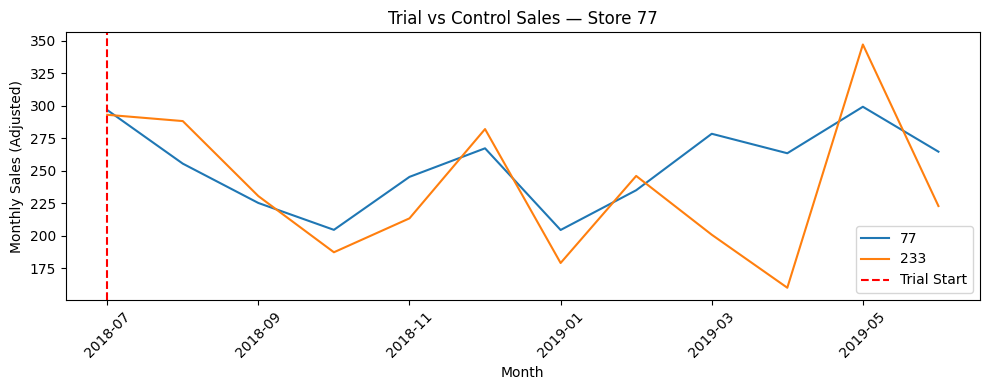

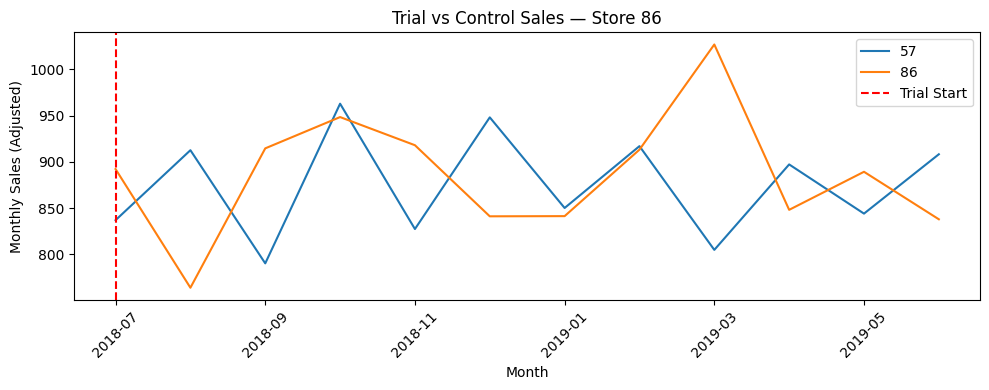

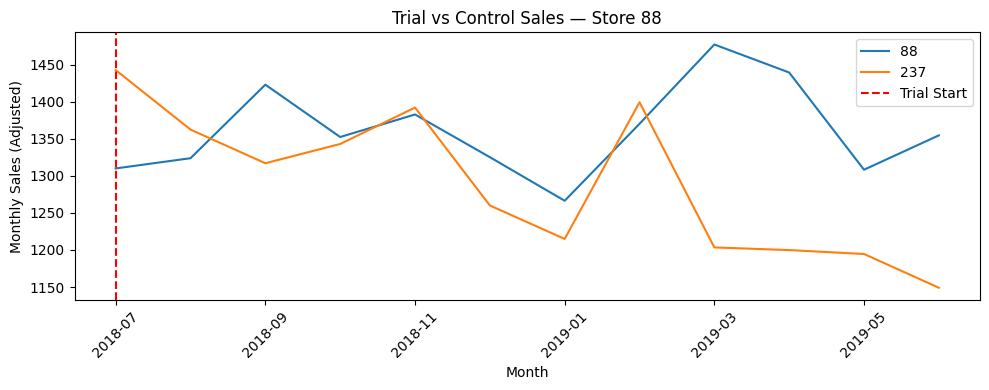

In [ ]:
import os

# Create folder to save charts
os.makedirs("trial_charts", exist_ok=True)

for trial in trial_stores:
    control = control_map.get(trial)

    if control is None:
        print(f" Skipping plot for trial store {trial} (no control).")
        continue

    # Data for both stores
    plot_df = monthly_store[
        monthly_store["STORE_NBR"].isin([trial, control])
    ].copy()

    # Scale control using PRE_TRIAL sales
    pre = plot_df[plot_df["PERIOD"] == "PRE_TRIAL"]

    scale = (
        pre.loc[pre["STORE_NBR"] == trial, "total_sales"].sum() /
        pre.loc[pre["STORE_NBR"] == control, "total_sales"].sum()
    )

    plot_df["sales_adj"] = plot_df["total_sales"]
    plot_df.loc[plot_df["STORE_NBR"] == control, "sales_adj"] *= scale

    # Pivot for plotting
    pivot = plot_df.pivot(
        index="YEAR_MONTH",
        columns="STORE_NBR",
        values="sales_adj"
    ).sort_index()

    # Plot
    pivot.plot(figsize=(10,4))
    plt.axvline(x=trial_start, color="red", linestyle="--", label="Trial Start")
    plt.title(f"Trial vs Control Sales — Store {trial}")
    plt.ylabel("Monthly Sales (Adjusted)")
    plt.xlabel("Month")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()

    # Save figure
    filename = f"trial_charts/trial_vs_control_store_{trial}.png"
    plt.savefig(filename)
    plt.show()


In [ ]:
final_summary = []

for _, row in uplift_df.iterrows():
    trial = int(row["Trial_Store"])
    control = int(row["Control_Store"])
    sales_uplift = row["Sales_Uplift_%"]

    # Driver info
    driver_row = driver_df[driver_df["Trial_Store"] == trial].iloc[0]
    cust_uplift = driver_row["Customer_Uplift_%"]
    freq_uplift = driver_row["Avg_Txn_per_Customer_Uplift_%"]

    # Verdict
    verdict = "SUCCESSFUL" if sales_uplift > 0 else "NOT SUCCESSFUL"

    # Main driver
    if cust_uplift > freq_uplift:
        driver = "Increase in number of customers"
    else:
        driver = "Increase in transactions per customer"

    final_summary.append({
        "Trial_Store": trial,
        "Control_Store": control,
        "Sales_Uplift_%": round(sales_uplift, 2),
        "Customer_Uplift_%": round(cust_uplift, 2),
        "Txn_per_Customer_Uplift_%": round(freq_uplift, 2),
        "Primary_Driver": driver,
        "Conclusion": verdict,
        "Recommendation": (
            "Roll out the trial to similar stores"
            if verdict == "SUCCESSFUL"
            else "Do not roll out; revise the trial approach"
        )
    })

final_df = pd.DataFrame(final_summary)
display(final_df)


,Trial_Store,Control_Store,Sales_Uplift_%,Customer_Uplift_%,Txn_per_Customer_Uplift_%,Primary_Driver,Conclusion,Recommendation
0,77,233,13.99,9.66,0.37,Increase in number of customers,SUCCESSFUL,Roll out the trial to similar stores
1,86,57,2.59,3.15,-1.13,Increase in number of customers,SUCCESSFUL,Roll out the trial to similar stores
2,88,237,11.61,3.69,6.26,Increase in transactions per customer,SUCCESSFUL,Roll out the trial to similar stores
